In [5]:
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download('soham1024/bitcoin-time-series-data-till-02082020')

print("Path to dataset files:", path)


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable

Path to dataset files: C:\Users\PC\.cache\kagglehub\datasets\soham1024\bitcoin-time-series-data-till-02082020\versions\1


In [114]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [115]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [116]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# Bitcoin Historical Data.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv(r'D:\Nam3_IUH\HK2_2024-2025\LTPTDL2\Lab\Week05\Bitcoin Historical Data.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'Bitcoin Historical Data.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 7 columns


In [117]:
df1.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,"Aug 02, 2020","11,105.8","11,802.6","12,061.1","10,730.7",698.62K,-5.91%
1,"Aug 01, 2020","11,803.1","11,333.2","11,847.7","11,226.1",611.47K,4.14%
2,"Jul 31, 2020","11,333.4","11,096.5","11,434.8","10,964.6",530.95K,2.14%
3,"Jul 30, 2020","11,096.2","11,105.8","11,164.4","10,861.6",501.14K,-0.09%
4,"Jul 29, 2020","11,105.9","10,908.4","11,336.5","10,771.8",576.83K,1.81%


In [118]:
# 2. Chuyển đổi dữ liệu đúng định dạng
cols_to_convert = ['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
for col in cols_to_convert:
    df1[col] = df1[col].astype(str).str.replace(',', '', regex=True)  # Xóa dấu phẩy
    df1[col] = df1[col].astype(str).str.replace('%', '', regex=True)  # Xóa dấu %
    df1[col] = pd.to_numeric(df1[col], errors='coerce')  # Chuyển thành float

In [119]:
# Chuyển đổi Date thành timestamp
df1['Date'] = pd.to_datetime(df1['Date'], errors='coerce')  
df1['Date'] = df1['Date'].astype('int64') // 10**9  # Chuyển thành timestamp (số giây từ 1970)

In [121]:
# 3. Hàm vẽ phân phối dữ liệu
def plotPerColumnDistribution(df, nGraphShown=10, nGraphPerRow=3):
    nunique = df.nunique()
    df_filtered = df[[col for col in df if 1 < nunique[col] < 50]]  # Giữ cột có 2-50 giá trị unique
    
    nRow, nCol = df_filtered.shape
    if nCol == 0:
        print("Không có cột nào phù hợp để vẽ biểu đồ phân phối.")
        return

    columnNames = list(df_filtered.columns)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow

    plt.figure(figsize=(6 * nGraphPerRow, 5 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df_filtered.iloc[:, i].dropna()  # Bỏ NaN trước khi vẽ
        
        if np.issubdtype(columnDf.dtype, np.number):
            columnDf.hist(bins=30, grid=True, edgecolor='black')
        else:
            columnDf.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

        plt.ylabel('Số lượng')
        plt.xticks(rotation=45)
        plt.title(f'{columnNames[i]}')

    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

In [122]:
# 4. Hàm vẽ ma trận tương quan
def plotCorrelationMatrix(df, graphWidth=10):
    filename = getattr(df, "dataframeName", "Unnamed DataFrame")
    
    df = df.dropna(axis=1)  # Xóa cột có toàn bộ giá trị NaN
    df = df[[col for col in df if df[col].nunique() > 1]]  # Giữ cột có hơn 1 giá trị duy nhất
    df = df.select_dtypes(include=[np.number])  # Giữ cột số
    
    if df.shape[1] < 2:
        print(f"Không đủ cột số để vẽ ma trận tương quan ({df.shape[1]} cột hợp lệ).")
        return

    corr = df.corr()

    plt.figure(figsize=(graphWidth, graphWidth))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)

    plt.title(f"Ma trận tương quan: {filename}", fontsize=15)
    plt.show()

In [123]:
# 5. Hàm vẽ Scatter Matrix
def plotScatterMatrix(df, plotSize=10, textSize=10):
    df = df.select_dtypes(include=[np.number])  # Giữ lại chỉ các cột số

    df = df.dropna(axis=1)  # Xóa cột có toàn bộ giá trị NaN
    df = df[[col for col in df if df[col].nunique() > 1]]  # Giữ cột có hơn 1 giá trị duy nhất
    
    if df.shape[1] < 2:
        print("Không có đủ cột số để vẽ scatter matrix.")
        return
    
    df = df.iloc[:, :10]  # Giới hạn 10 cột để tránh lỗi singular matrix

    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')

    corrs = df.corr().values
    upper_tri_indices = np.triu_indices_from(corrs, k=1)
    for i, j in zip(*upper_tri_indices):
        ax[i, j].annotate(f'Corr. coef = {corrs[i, j]:.3f}', (0.8, 0.2), 
                          xycoords='axes fraction', ha='center', va='center', size=textSize)

    plt.suptitle('Scatter and Density Plot')
    plt.show()


In [124]:
plotPerColumnDistribution(df1, 10, 5)

Không có cột nào phù hợp để vẽ biểu đồ phân phối.


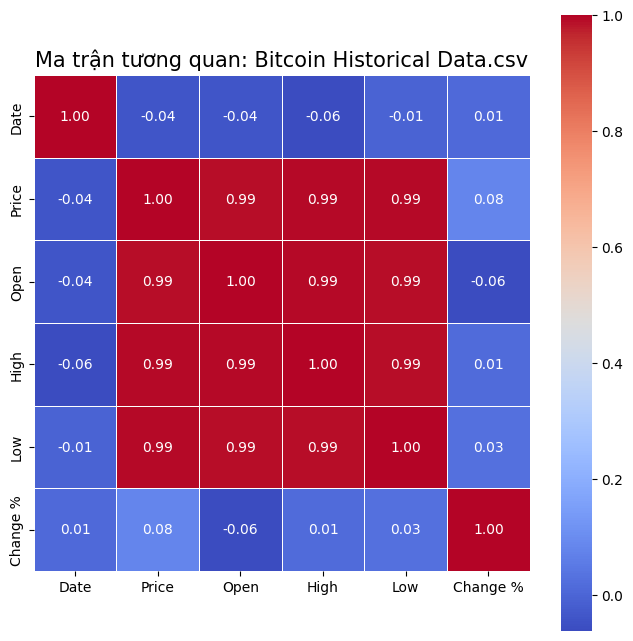

In [125]:
plotCorrelationMatrix(df1, 8)

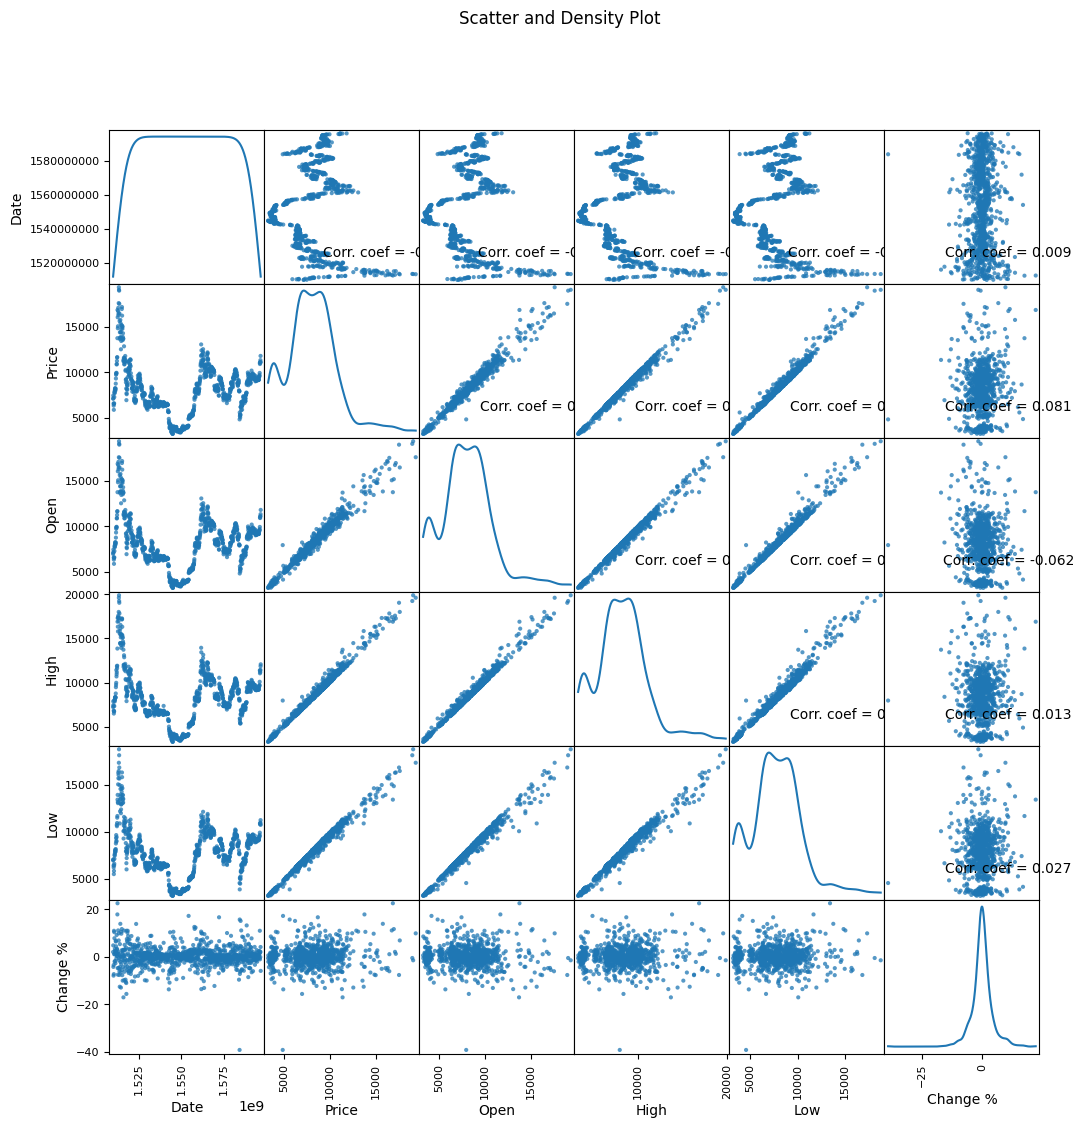

In [126]:
plotScatterMatrix(df1, 12, 10)